In [35]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

In [2]:
# Load data
dfs = []
dfs.append(pd.read_csv('data/brand1.csv'))
dfs.append(pd.read_csv('data/brand2.csv'))
dfs.append(pd.read_csv('data/brand3.csv'))

In [3]:
# Display data
for i in range(3):

    # Show information for each brand
    print("\n=====================================\n")
    print(f"Brand {i+1}\n")

    # Show proportion of 0s and 1s
    zero_count = (dfs[i]['label'] == 0).sum()
    one_count = (dfs[i]['label'] == 1).sum()
    print("Number of 0s:", zero_count)
    print("Number of 1s:", one_count)
    print("Data proportion of 0s:", zero_count / (zero_count + one_count), "\n")

    # Show all cars
    print("Cars with corresponding labels and sample counts:")
    cars = dfs[i]['car'].value_counts().sort_index()
    for car, count in cars.items():
        label = dfs[i].loc[dfs[i]['car'] == car, 'label'].iloc[0]
        print(f"Car {car}, Label {label}, Count {count}")



Brand 1

Number of 0s: 58842624
Number of 1s: 2179968
Data proportion of 0s: 0.9642760504175241 

Cars with corresponding labels and sample counts:
Car 1, Label 0, Count 350208
Car 2, Label 0, Count 10752
Car 3, Label 0, Count 552832
Car 4, Label 0, Count 76416
Car 5, Label 0, Count 136320
Car 6, Label 0, Count 97024
Car 7, Label 0, Count 293888
Car 8, Label 0, Count 110720
Car 9, Label 0, Count 435456
Car 10, Label 0, Count 434944
Car 11, Label 0, Count 560640
Car 12, Label 0, Count 149248
Car 13, Label 0, Count 768
Car 14, Label 0, Count 172544
Car 15, Label 0, Count 198912
Car 16, Label 0, Count 491392
Car 17, Label 0, Count 112256
Car 18, Label 0, Count 10496
Car 19, Label 0, Count 427904
Car 20, Label 0, Count 463616
Car 21, Label 1, Count 7424
Car 22, Label 0, Count 258688
Car 23, Label 0, Count 73344
Car 24, Label 0, Count 95232
Car 25, Label 0, Count 108416
Car 26, Label 0, Count 109696
Car 27, Label 0, Count 1067648
Car 28, Label 0, Count 371840
Car 29, Label 0, Count 93568


In [7]:
# Process Data
for i in range(3):

    # Remove empty rows
    dfs[i] = dfs[i].dropna().reset_index(drop=True)

    # Drop irrlevant columns
    dfs[i] = dfs[i].drop(columns=['car'], axis=1, errors='ignore')

    # Normalize all columns
    for column in dfs[i].columns:
        if column != 'label':
            dfs[i][column] = (dfs[i][column] - dfs[i][column].mean()) / dfs[i][column].std()


In [18]:
# Seperate input and output
data = []
for i, df in enumerate(dfs):
    X = df.drop(['label'], axis=1)
    Y = df['label']

    X = torch.tensor(X.values, dtype=torch.float32)
    Y = torch.tensor(Y.values, dtype=torch.float32).reshape(-1, 1)
    print("Brand", i+1)
    print("X tensor:", X.shape)
    print("Y tensor:", Y.shape)

    data.append((X, Y))

Brand 1
X tensor: torch.Size([61022592, 9])
Y tensor: torch.Size([61022592, 1])
Brand 2
X tensor: torch.Size([24863360, 9])
Y tensor: torch.Size([24863360, 1])
Brand 3
X tensor: torch.Size([3788544, 9])
Y tensor: torch.Size([3788544, 1])


In [19]:
# Neural Network
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(9, 9)
        self.act = nn.ReLU()
        self.output = nn.Linear(9, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.layer(x))
        x = self.act(self.layer(x))
        x = self.act(self.layer(x))
        x = self.sigmoid(self.output(x))
        return x

In [20]:
# Load models
MODEL_PATH_1 = "05-02_13-23-45_brand1.pth"
MODEL_PATH_2 = "05-02_06-01-11_brand2.pth"
MODEL_PATH_3 = "05-02_05-12-36_brand3.pth"

models = []
for path in [MODEL_PATH_1, MODEL_PATH_2, MODEL_PATH_3]:
    model = Deep()
    model.load_state_dict(torch.load('./models/v2_large_epochs/results/' + path))
    models.append(model)

In [38]:
# Test models
rocs = []
aucs = []
for i, model in enumerate(models):
    X, Y = data[i]
    model.eval()
    Y_pred = model(X)
    print("\n=====================================")
    print("Brand", i+1)

    # Calculate accuracy
    acc = ((Y_pred > 0.5) == Y).sum().item() / Y.shape[0]
    print(f"Accuracy (0.5 threshold): {acc:.6f}")

    # Convert true and predicted values to numpy
    Y_pred = Y_pred.detach().numpy()
    Y = Y.numpy()
    
    # Calculate ROC curve
    roc = roc_curve(Y, Y_pred)
    auc = roc_auc_score(Y, Y_pred)
    rocs.append(roc)
    aucs.append(auc)
    print(f"AUC: {auc:.6f}")
    



Brand 1
Accuracy (0.5 threshold): 0.973933
AUC: 0.924904

Brand 2
Accuracy (0.5 threshold): 0.952701
AUC: 0.989497

Brand 3
Accuracy (0.5 threshold): 0.964940
AUC: 0.975742



Brand 1
AUC: 0.924904

Brand 2
AUC: 0.989497

Brand 3
AUC: 0.975742



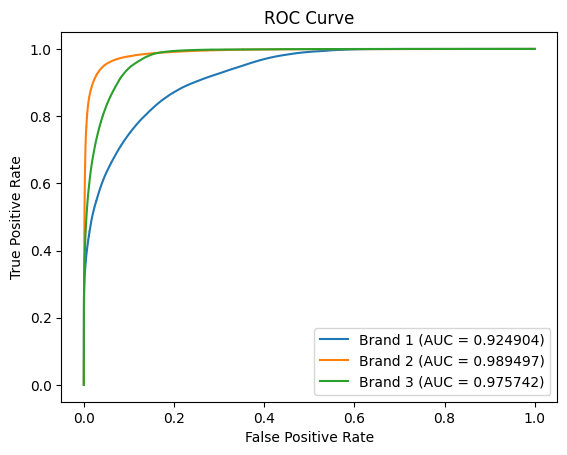

In [45]:
# Plot ROC curves
for i in range(3):
    roc, auc = rocs[i], aucs[i]
    fpr, tpr, _ = roc
    print("\n=====================================")
    print("Brand", i+1)
    print(f"AUC: {auc:.6f}")

    plt.plot(fpr, tpr, label=f"Brand {i+1} (AUC = {auc:.6f})")

# Label plot
print("\n=====================================")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
    
